In [100]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [13]:
data = pd.read_csv('../../data/telecom_churn.csv')

In [14]:
data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [15]:
data.drop(['State', 'Voice mail plan'], axis = 1, inplace = True)

In [16]:
data['International plan'] = data['International plan'].map({'Yes': 1, 'No': 0})

In [18]:
y = data['Churn'].astype('int')

In [19]:
X = data.drop('Churn', axis = 1)

In [20]:
X.shape, y.shape

((3333, 17), (3333,))

In [27]:
from sklearn.model_selection import train_test_split, cross_val_score

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 17)

In [24]:
X_train.shape, X_valid.shape

((2333, 17), (1000, 17))

In [25]:
first_tree = DecisionTreeClassifier(random_state = 17)

In [29]:
cross_val_score(first_tree, X_train, y_train, cv=5)

array([ 0.9143469 ,  0.91220557,  0.92291221,  0.90772532,  0.91416309])

In [30]:
np.mean(cross_val_score(first_tree, X_train, y_train, cv=5))

0.91427061602227722

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
first_knn = KNeighborsClassifier()

In [34]:
np.mean(cross_val_score(first_knn, X_train, y_train, cv=5))

0.86712740439845226

# Настраеваем max_depth для дерева

In [35]:
from sklearn.model_selection import GridSearchCV

In [56]:
tree_params = {'max_depth': np.arange(1, 11), 'max_features': np.arange(0.5, 0.7)}

In [49]:
tree_grid = GridSearchCV(first_tree, tree_params, cv=5, n_jobs=-1)

In [50]:
%%time
tree_grid.fit(X_train, y_train)

CPU times: user 110 ms, sys: 90 ms, total: 200 ms
Wall time: 456 ms


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'max_features': array([ 0.5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [53]:
tree_grid.best_score_, tree_grid.best_params_

(0.93741963137591089, {'max_depth': 6, 'max_features': 0.5})

In [67]:
knn_params = {'n_neighbors': range(5, 30, 5)}

In [68]:
knn_grid = GridSearchCV(first_knn, knn_params, cv=5)

In [69]:
%%time
knn_grid.fit(X_train, y_train)

CPU times: user 1.85 s, sys: 0 ns, total: 1.85 s
Wall time: 1.85 s


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(5, 30, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [70]:
knn_grid.best_score_, knn_grid.best_params_

(0.8701243034719246, {'n_neighbors': 10})

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=0.5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [76]:
tree_valid_pred = tree_grid.predict(X_valid)

In [74]:
tree_grid.score(X_valid, y_valid)

0.94199999999999995

In [75]:
from sklearn.metrics import accuracy_score

In [77]:
accuracy_score(y_valid, tree_valid_pred)

0.94199999999999995

In [79]:
# baseline, модель, которая предсказывает всегда, 
# что человек «хороший»
1 - np.mean(y) 

0.85508550855085508

In [80]:
from sklearn.tree import export_graphviz

In [81]:
export_graphviz(tree_grid.best_estimator_, out_file = 'telecom_tree.dot', feature_names = X.columns, filled=True)

In [83]:
!dot -Tpng telecom_tree.dot -o telecom_tree.png

/bin/sh: 1: dot: not found


<img src='telecom_tree.png'>

# Test

In [104]:
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font='DejaVu Sans')

In [106]:
a = np.random.normal(size=(100, 2))

In [107]:
b = np.r_[a, np.random.normal(size=(5, 2), loc=2)]

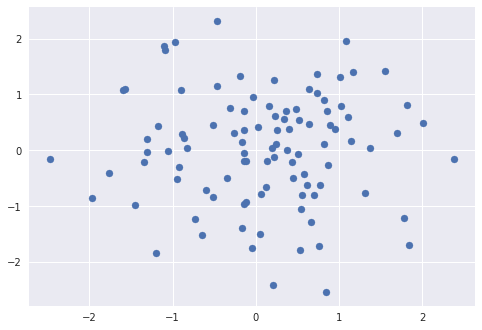

In [108]:
plt.scatter(a[:, 0], a[:, 1]);
plt.plot();

In [111]:
DecisionTreeClassifier?

In [112]:
np.c_?

In [118]:
import numpy as np
mg = np.meshgrid()

In [119]:
mg.ravel?

Object `mg.ravel` not found.
